# 2. Monolithic AD & ML Approaches and Why They are Unsatisfactory

Given the abundance of normal driving data, the problem naturally leads to an anomaly detection (AD) formulation. Let’s try some off-the-shell well-known methods for example Isolation Forest!

In theory, AD approach isn't affected by the Cold Start problem as training data is normal data only, and is hence we only need labels during evaluation of the intrusion detection system.

But will it work accurately enough? Let's try!

### 2a. A naive AD approach using IsolationForest

In [29]:
import pandas as pd

df_train = pd.read_parquet("s3://h1st-tutorial-autocyber/attack-samples/20181116_Driver1_Trip4-0.parquet")

df_train[df_train.AttackEventIndex==1].head(20)

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label,AttackSensor,AttackMethod,AttackParams,AttackEventIndex
21768,101.062936,NaN,NaN,2.380646,0.349023,0.463921,Normal,NA,NA,0.000000,1
21769,101.064817,13.3680,NaN,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
21770,101.073021,NaN,NaN,2.363797,0.351361,0.459190,Normal,NA,NA,0.000000,1
21771,101.073533,NaN,NaN,2.397497,0.351361,0.459190,Attack,YawRate,quadratic,0.252221,1
21772,101.077089,13.2808,NaN,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
21773,101.078002,NaN,34.59,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
21774,101.085562,NaN,NaN,2.346948,0.353699,0.454460,Normal,NA,NA,0.000000,1
21775,101.085998,NaN,NaN,2.397515,0.353699,0.454460,Attack,YawRate,quadratic,0.252221,1
21776,101.088035,13.1936,NaN,NaN,NaN,NaN,Normal,NA,NA,0.000000,1
21777,101.096243,NaN,NaN,2.330098,0.356037,0.449729,Normal,NA,NA,0.000000,1


What did you notice based on the sequencing of the CAN messages? There seems to be particular rhythms.

Let's include timing-based features, such as time diff since last message of the same type. 

In [40]:
SENSORS = ["SteeringAngle", "CarSpeed", "YawRate", "Gx", "Gy"]
df_train_filled = df_train.copy()

for s in SENSORS:
    sensor_not_isna = df_train_filled[~df_train_filled[s].isna()]
    df_train_filled["%s_TimeDiff" % s] = sensor_not_isna.Timestamp - sensor_not_isna.shift(1).Timestamp

We can clearly visualize that attack and normal messages have different timing distribution. Normal YawRate messages typically comes every 12.5ms, and the attack messages are injected much closer to previous messages (smaller time diffs).

Can AD make use of this?

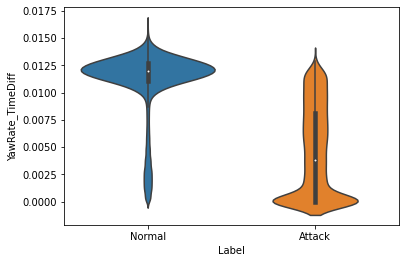

In [48]:
import seaborn
seaborn.violinplot(data=df_train_filled, y="YawRate_TimeDiff", x="Label")

Also, we need to handle the NaN values due to the unique feature of CAN bus data, i.e. YawRate/Gx/Gy is a different CAN message than SteeringAngle or CarSpeed.

In [54]:
from sklearn.ensemble import IsolationForest

FEATURES = SENSORS + ["%s_TimeDiff" % s for s in SENSORS]

def compute_timediff_fillna(df):
    df = df.copy()
    for s in SENSORS:
        sensor_not_isna = df[~df[s].isna()]
        df["%s_TimeDiff" % s] = sensor_not_isna.Timestamp - sensor_not_isna.shift(1).Timestamp
    #print(df.head(20))

    for s in SENSORS:
        df[s] = df[s].fillna(method="ffill")
        df["%s_TimeDiff" % s] = df["%s_TimeDiff" % s].fillna(-1)
    df.dropna(subset=FEATURES, inplace=True)
    
    return df

df_train_filled = compute_timediff_fillna(df_train)

iforest = IsolationForest(n_estimators=500).fit(df_train_filled[FEATURES])

In [55]:
import numpy as np
import sklearn.metrics

df_test = pd.read_parquet("s3://h1st-tutorial-autocyber/attack-samples/20181203_Driver1_Trip9-0.parquet")
df_test_filled = compute_timediff_fillna(df_test)

In [56]:
ypred = iforest.predict(df_test_filled[FEATURES])

ypred = pd.Series(np.maximum(-ypred, 0)) # iforest predict -1 vs 1, we need 0 vs 1
cf = sklearn.metrics.confusion_matrix(df_test_filled.Label == "Attack", ypred)
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df_test_filled.Label =="Attack", ypred))

[[220755  56806]
 [  1475  12462]]
Accuracy = 0.8000638083280159 


This is certainly a start. But the accuracy is no where near what’s needed for deployment, especially FPR (false positive rate)! In fact, a majority of predictions are false positives.

While there are a lot of exciting approaches for AD and sequential time-series data, including using RNN/LSTM/CNN, autoencoders, self-supervised learning, etc. The fundamental problem with AD is that it is hard to achieve high TPR while simultaneously achieving very low FPR which is what we need.

Since AD after all, is a harder problem than supervised learning and while they are important parts of the tool box, we need another strategy to tackle the problem.

### 2b. Machine teaching: leveraging ML to "program" a classifier by specifying human-generated outputs

If we zoom in, it is perhaps easier to see the zig-zag patterns of alternating real vs injected messages. It's clear that perhaps we can leverage a ML to classify these kinds of smooth vs zig-zag patterns.

After all, ML should excel at pattern recognition.

The significance of this approach is that it is much easier for human experts to synthesize the attack data than to write the detection program. And such is the promise of Software 2.0, but will it work?

Let's inspect closely one such attack event.

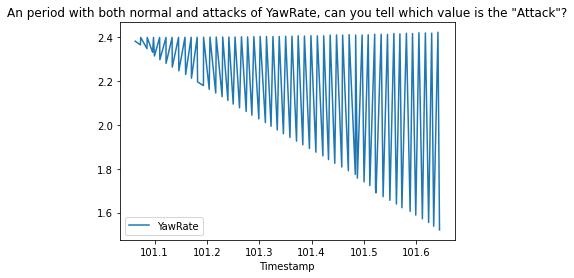

In [11]:
z = df_train[df_train.AttackEventIndex==1]
z = z[~z.YawRate.isna()].set_index("Timestamp")

import matplotlib.pyplot as plt
z.iloc[:100].YawRate.plot(label="YawRate")
plt.title('An period with both normal and attacks of YawRate, can you tell which value is the "Attack"?')
plt.legend()
plt.show()

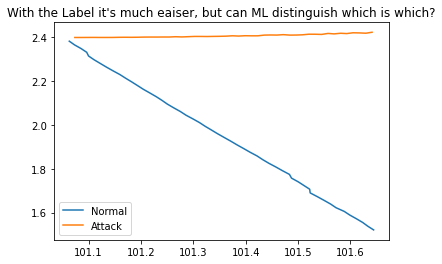

In [12]:
import matplotlib.pyplot as plt
plt.figure()
z = z.iloc[:100].reset_index() # pop Timestamp attribute
znorm = z[z.Label == "Normal"]
plt.plot(znorm.Timestamp, znorm.YawRate, label="Normal")
zattk = z[z.Label == "Attack"]
plt.plot(zattk.Timestamp, zattk.YawRate, label="Attack")
plt.legend()
plt.title("With the Label it's much eaiser, but can ML distinguish which is which?")
plt.show()

Let’s try a gradient-boosted trees firstly, e.g. sklearn’s HistGradientBoostingClassifier can work well on larger dataset before bringing out bigger guns.

In [57]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

gbc = HistGradientBoostingClassifier(max_iter=500).fit(df_train_filled[FEATURES], df_train_filled.Label == "Attack")

In [58]:
import numpy as np

ypred = gbc.predict(df_test_filled[FEATURES])

cf = sklearn.metrics.confusion_matrix(df_test_filled.Label == "Attack", ypred)
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df_test_filled.Label == "Attack", ypred))

[[277041    520]
 [  5277   8660]]
Accuracy = 0.9801130711016885 


Impressive as it seems, we must note that the false-positive rate is still a bit high at FPR = 520/(520+8660) = 5.66%.  Since CAN messages are very frequent (100-200 msgs/sec in each car), this is still no where near deployment-ready!

We can certainly improve results by tuning the model, tuning the fill-NA method, or bring out larger guns like Bidirectional LSTM or CNN or Transformers which can work well on pattern recognition problems on sequential data such as this problem. Powerful deep learning models can recognize these attack patterns well, and can be trained much faster on the full dataset which is quite large in our case.

However, we must reckon that these models, after all, are recognizing attack patterns that humans are generating and injecting artificially. While this is convenient to generate output and train the detector program a la “Software 2.0”, for our situation, because the attacks are purely synthetic, we cannot be too sure that they are learning the right things and work robustly and can be trusted to deploy in the field. It’s best to employ them in the right deployment scope, namely useful pattern recognizers.